# U.S. Geological Survey Class GW3099
Advanced Modeling of Groundwater Flow (GW3099)\
Boise, Idaho\
September 16 - 20, 2024

![title](../../images/ClassLocation.jpg)

# One-Dimensional Compaction in a Three-Dimensional Flow Field

This problem is based on the problem presented in the SUB-WT report ([Leake and Galloway, 2007](https://doi.org/10.3133/tm6A23)) and represent groundwater development in a hypothetical aquifer that includes some features typical of basin-fill aquifers in an arid or semi-arid environment.

<div>
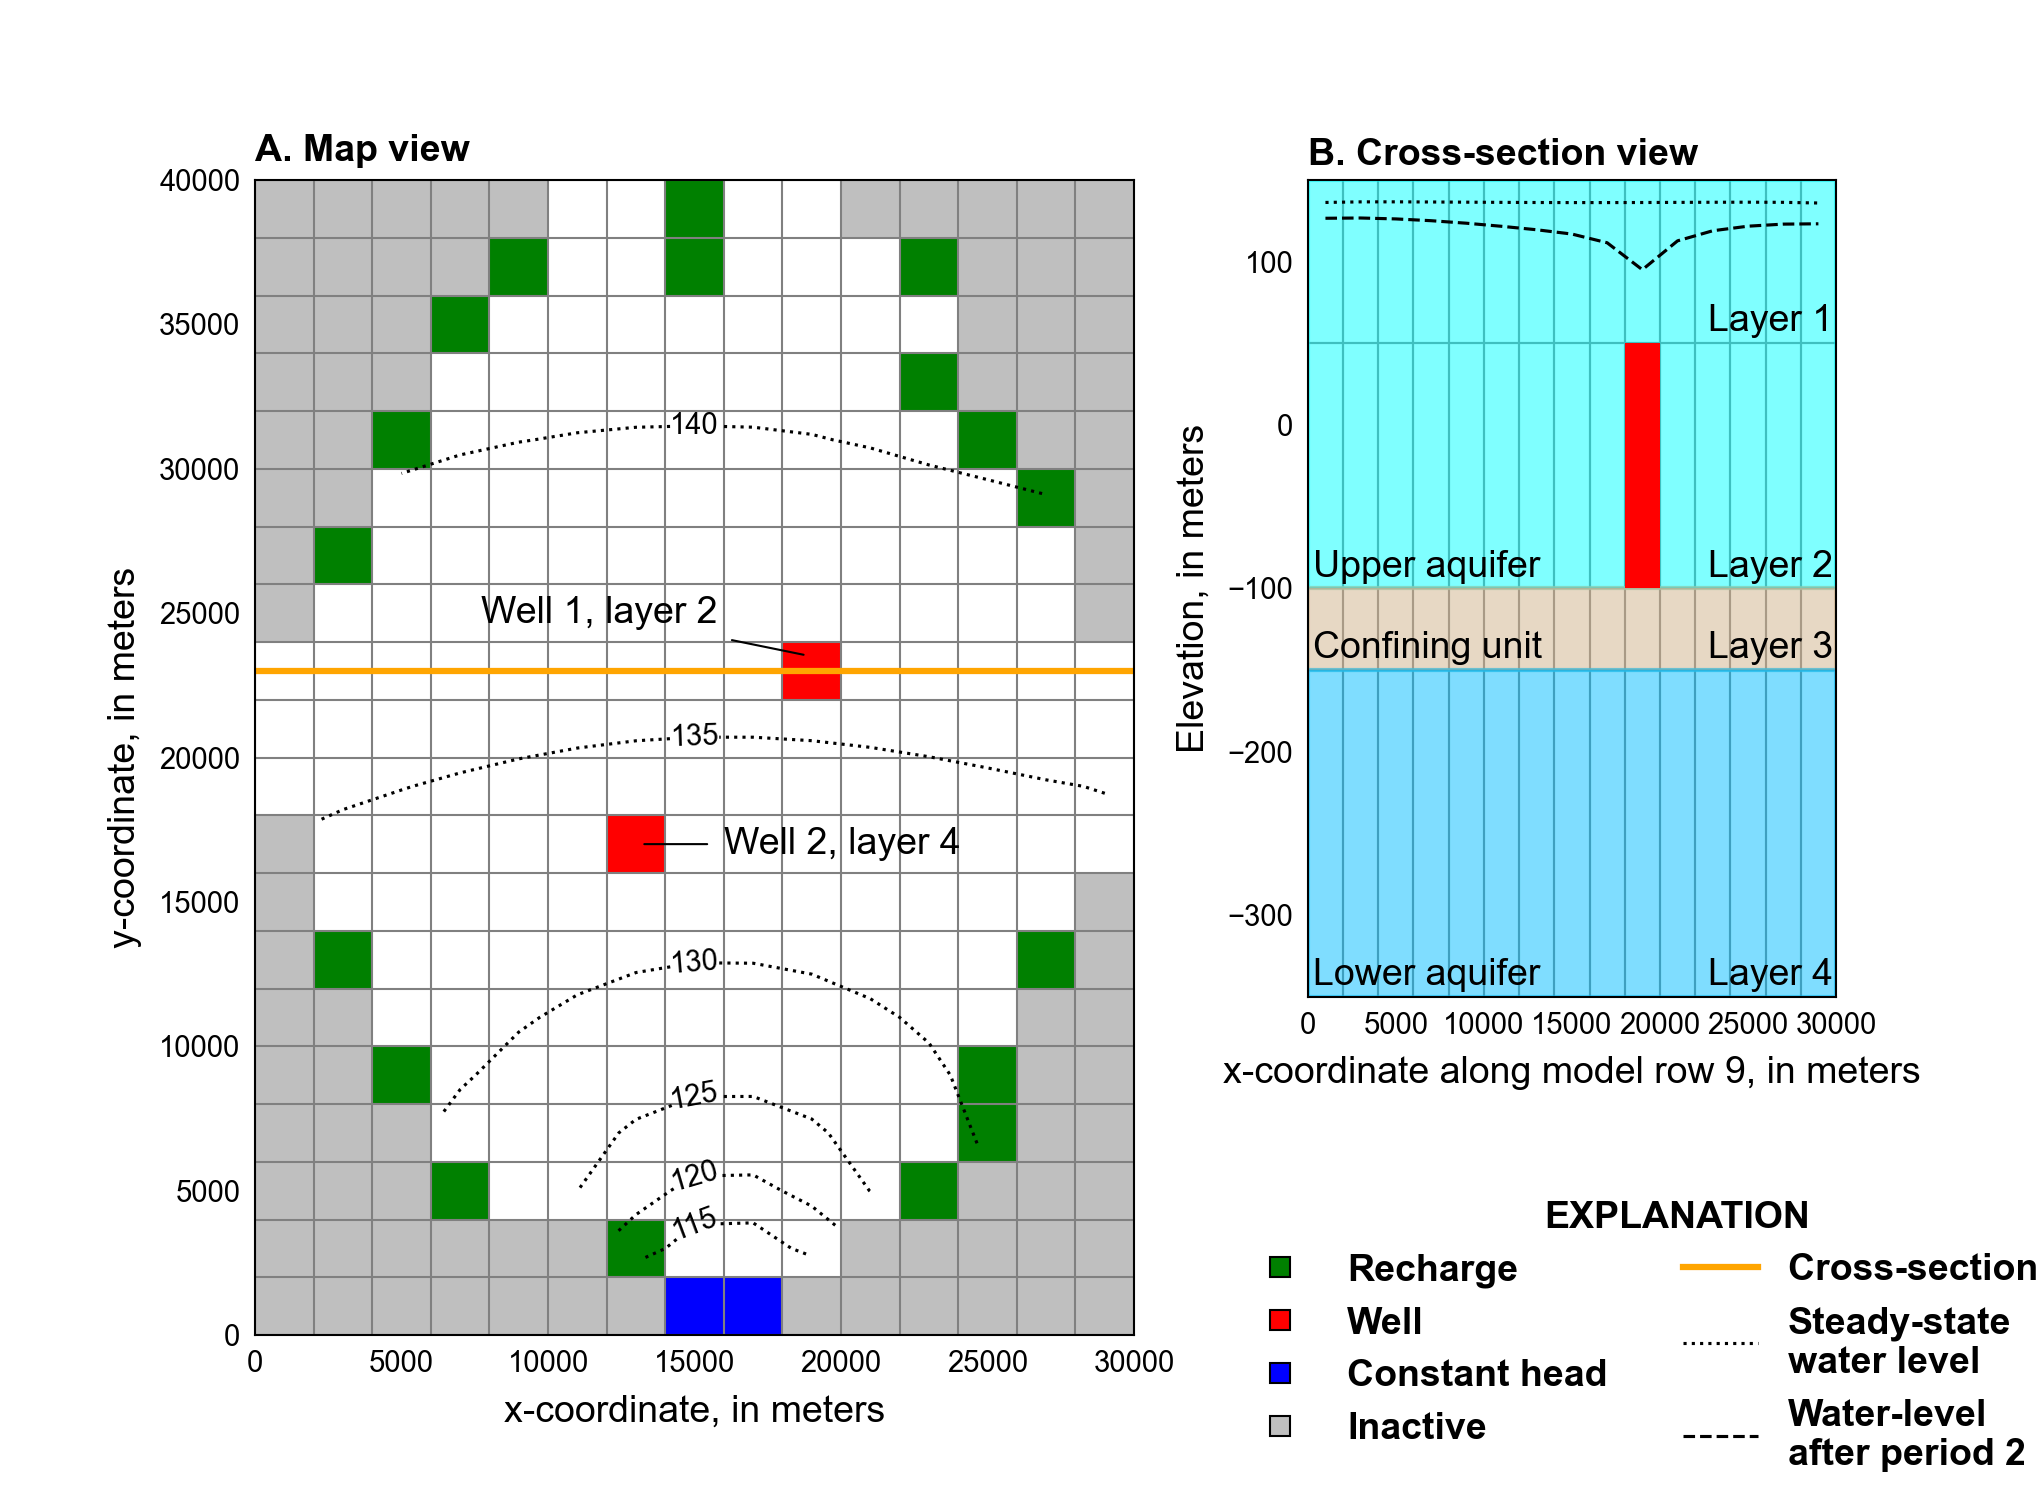
</div>

In [ ]:
import pathlib as pl

import flopy
import matplotlib.pyplot as plt
import numpy as np
import pooch

In [ ]:
name = "csub-ex2"
ws = pl.Path(f"temp/{name}")

## Model Setup

In [ ]:
length_units = "meters"
time_units = "days"

In [ ]:
nper = 3
nlay = 4
nrow = 20
ncol = 15
delr = 2000.0
delc = 2000.0
top = 150.0
botm = [50.0, -100.0, -150.0, -350.0]

In [ ]:
tdis_ds = (
    (0.0, 1, 1.0),
    (21915.0, 60, 1.0),
    (21915.0, 60, 1.0),
)

In [ ]:
strt = 100.0

In [ ]:
# npf data
icelltype = [1, 0, 0, 0]
k11 = [4.0, 4.0, 0.01, 4.0]
k33 = [0.4, 0.4, 0.01, 0.4]

In [ ]:
# storage properties
sy = [0.3, 0.3, 0.4, 0.3]  # Specific yield (unitless)
gammaw = 9806.65  # Compressibility of water (Newtons/m^3)
beta = 4.6612e-10  # Specific gravity of water (1/Pa)
sgm = [1.77, 1.77, 1.60, 1.77]  # Specific gravity of moist soils (unitless)
sgs = [
    2.06,
    2.05,
    1.94,
    2.06,
]  # Specific gravity of saturated soils (unitless)
cg_theta = [
    0.32,
    0.32,
    0.45,
    0.32,
]  # Coarse-grained material porosity (unitless)
cg_ske = [0.005, 0.005, 0.01, 0.005]  # Elastic specific storage (1/m)
ib_thick = [45.0, 70.0, 50.0, 90.0]  # Interbed thickness (m)
ib_theta = 0.45  # Interbed initial porosity (unitless)
ib_cr = 0.01  # Interbed recompression index (unitless)
ib_cv = 0.25  # Interbed compression index (unitless)
stress_offset = 15.0  # Initial preconsolidation stress offset (m)

In [ ]:
# Define the active domain and create idomain array
fname = "idomain.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/ex-gwf-csub-p04/{fname}",
    fname=fname,
    path=ws,
    known_hash="md5:2f05a27b6f71e564c0d3616e3fd00ac8",
)

ib = np.loadtxt(fpath, dtype=int)

In [ ]:
# set ib to 3 in chd locations
chd_locs = (
    np.array([nrow - 1, nrow - 1], dtype=int),
    np.array([7, 8], dtype=int),
)
ib[chd_locs] = 3

In [ ]:
plt.imshow(ib)
plt.colorbar()

In [ ]:
# create a 3-D idomain array
idomain = np.array([ib for i in range(nlay)])

In [ ]:
idomain.shape, ib.shape

In [ ]:
# Constant head boundary cells
c6 = []
for k in range(nlay):
    for i, j in zip(chd_locs[0], chd_locs[1]):
        c6.append([k, int(i), int(j), strt])

In [ ]:
c6

In [ ]:
# Recharge boundary cells
rch_rate = 5.5e-4
rch6 = []
idxs = np.asarray(ib == 2).nonzero()
for i, j in zip(idxs[0], idxs[1]):
    rch6.append([0, int(i), int(j), rch_rate])

In [ ]:
# Well boundary cells
well_locs = (
    (1, 8, 9),
    (3, 11, 6),
)
well_rates = (
    -72000,
    0.0,
)
wel6 = {}
for idx, q in enumerate(well_rates):
    spd = []
    for k, i, j in well_locs:
        spd.append([k, i, j, q])
    wel6[idx + 1] = spd

In [ ]:
# Create interbed package data
idxs = np.asarray((ib > 0) & (ib < 3)).nonzero()
icsubno = 0
csub_pakdata = []
for k in range(nlay):
    for i, j in zip(idxs[0], idxs[1]):
        boundname = f"{k + 1:02d}_{i + 1:02d}_{j + 1:02d}"
        ib_lst = [
            icsubno,
            (k, int(i), int(j)),
            "nodelay",
            stress_offset,
            ib_thick[k],
            1.0,
            ib_cv,
            ib_cr,
            ib_theta,
            999.0,
            999.0,
            boundname,
        ]
        csub_pakdata.append(ib_lst)
        icsubno += 1

## Create the model files

In [ ]:
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws)
flopy.mf6.ModflowTdis(
    sim, nper=nper, perioddata=tdis_ds, time_units=time_units
)
flopy.mf6.ModflowIms(
    sim,
    complexity="simple",
    outer_dvclose=1e-8,
    linear_acceleration="bicgstab",
    inner_dvclose=1e-9,
    relaxation_factor=0.97,
    rcloserecord=f"{1e-6} strict",
)

In [ ]:
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=name, save_flows=True, newtonoptions="newton"
)
flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
)
# gwf obs
flopy.mf6.ModflowUtlobs(
    gwf,
    print_input=True,
    continuous={
        f"{name}.gwf.obs.csv": [
            ("h1l1", "HEAD", (0, 8, 9)),
            ("h1l2", "HEAD", (1, 8, 9)),
            ("h1l3", "HEAD", (2, 8, 9)),
            ("h1l4", "HEAD", (3, 8, 9)),
            ("h2l1", "HEAD", (0, 11, 6)),
            ("h2l2", "HEAD", (1, 11, 6)),
            ("h3l2", "HEAD", (2, 11, 6)),
            ("h4l2", "HEAD", (3, 11, 6)),
        ]
    },
)

flopy.mf6.ModflowGwfic(gwf, strt=strt)
flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=icelltype,
    k=k11,
    save_specific_discharge=True,
)
flopy.mf6.ModflowGwfsto(
    gwf,
    iconvert=icelltype,
    ss=0.0,
    sy=sy,
    steady_state={0: True},
    transient={1: True},
)

In [ ]:
csub = flopy.mf6.ModflowGwfcsub(
    gwf,
    print_input=True,
    save_flows=True,
    compression_indices=True,
    update_material_properties=True,
    boundnames=True,
    ninterbeds=len(csub_pakdata),
    sgm=sgm,
    sgs=sgs,
    cg_theta=cg_theta,
    cg_ske_cr=cg_ske,
    beta=beta,
    gammaw=gammaw,
    packagedata=csub_pakdata,
)

In [ ]:
opth = f"{name}.csub.obs"
csub_csv = opth + ".csv"
obs = [
    ("w1l1", "interbed-compaction", "01_09_10"),
    ("w1l2", "interbed-compaction", "02_09_10"),
    ("w1l3", "interbed-compaction", "03_09_10"),
    ("w1l4", "interbed-compaction", "04_09_10"),
    ("w2l1", "interbed-compaction", "01_12_07"),
    ("w2l2", "interbed-compaction", "02_12_07"),
    ("w2l3", "interbed-compaction", "03_12_07"),
    ("w2l4", "interbed-compaction", "04_12_07"),
    ("s1l1", "coarse-compaction", (0, 8, 9)),
    ("s1l2", "coarse-compaction", (1, 8, 9)),
    ("s1l3", "coarse-compaction", (2, 8, 9)),
    ("s1l4", "coarse-compaction", (3, 8, 9)),
    ("s2l1", "coarse-compaction", (0, 11, 6)),
    ("s2l2", "coarse-compaction", (1, 11, 6)),
    ("s2l3", "coarse-compaction", (2, 11, 6)),
    ("s2l4", "coarse-compaction", (3, 11, 6)),
    ("c1l1", "compaction-cell", (0, 8, 9)),
    ("c1l2", "compaction-cell", (1, 8, 9)),
    ("c1l3", "compaction-cell", (2, 8, 9)),
    ("c1l4", "compaction-cell", (3, 8, 9)),
    ("c2l1", "compaction-cell", (0, 11, 6)),
    ("c2l2", "compaction-cell", (1, 11, 6)),
    ("c2l3", "compaction-cell", (2, 11, 6)),
    ("c2l4", "compaction-cell", (3, 11, 6)),
    ("w2l4q", "csub-cell", (3, 11, 6)),
    ("gs1", "gstress-cell", (0, 8, 9)),
    ("es1", "estress-cell", (0, 8, 9)),
    ("pc1", "preconstress-cell", (0, 8, 9)),
    ("gs2", "gstress-cell", (1, 8, 9)),
    ("es2", "estress-cell", (1, 8, 9)),
    ("pc2", "preconstress-cell", (1, 8, 9)),
    ("gs3", "gstress-cell", (2, 8, 9)),
    ("es3", "estress-cell", (2, 8, 9)),
    ("pc3", "preconstress-cell", (2, 8, 9)),
    ("gs4", "gstress-cell", (3, 8, 9)),
    ("es4", "estress-cell", (3, 8, 9)),
    ("pc4", "preconstress-cell", (3, 8, 9)),
    ("sk1l2", "ske-cell", (1, 8, 9)),
    ("sk2l4", "ske-cell", (3, 11, 6)),
    ("t1l2", "theta", "02_09_10"),
    ("w1qie", "elastic-csub", "02_09_10"),
    ("w1qii", "inelastic-csub", "02_09_10"),
    ("w1qaq", "coarse-csub", (1, 8, 9)),
    ("w1qt", "csub-cell", (1, 8, 9)),
    ("w1wc", "wcomp-csub-cell", (1, 8, 9)),
    ("w2qie", "elastic-csub", "04_12_07"),
    ("w2qii", "inelastic-csub", "04_12_07"),
    ("w2qaq", "coarse-csub", (3, 11, 6)),
    ("w2qt ", "csub-cell", (3, 11, 6)),
    ("w2wc", "wcomp-csub-cell", (3, 11, 6)),
]
orecarray = {csub_csv: obs}
csub.obs.initialize(filename=opth, print_input=True, continuous=orecarray)

In [ ]:
flopy.mf6.ModflowGwfchd(
    gwf, stress_period_data={0: c6}, maxbound=len(c6), pname="chd-1"
)

In [ ]:
flopy.mf6.ModflowGwfrch(
    gwf, stress_period_data={0: rch6}, maxbound=len(rch6), pname="rch-1"
)

In [ ]:
flopy.mf6.ModflowGwfwel(
    gwf, stress_period_data=wel6, maxbound=len(wel6), pname="wel-1"
)

In [ ]:
flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{name}.hds",
    budget_filerecord=f"{name}.cbc",
    printrecord=[("BUDGET", "ALL")],
    saverecord=[("BUDGET", "ALL"), ("HEAD", "ALL")],
)

### Write the model files

In [ ]:
sim.write_simulation()

### Run the model

In [ ]:
sim.run_simulation()

## Post-process the compaction results

In [ ]:
plot_tags = (
    "W1L",
    "W2L",
    "S1L",
    "S2L",
    "C1L",
    "C2L",
)
compaction_heading = ("row 9, column 10", "row 12, column 7")

In [ ]:
stress_obs = gwf.csub.output.obs().data
stress_obs["totim"] /= 365.25

# set initial preconsolidation stress to stress period 1 value
slist = [name for name in stress_obs.dtype.names if "PC" in name]
for tag in slist:
    stress_obs[tag][0] = stress_obs[tag][1]

# set initial storativity to stress period 1 value
sk_tags = (
    "SK1L2",
    "SK2L4",
)
for tag in sk_tags:
    if tag in stress_obs.dtype.names:
        stress_obs[tag][0] = stress_obs[tag][1]

In [ ]:
comp_obs = stress_obs.copy()
for tag in plot_tags:
    for k in (
        3,
        2,
        1,
    ):
        tag0 = f"{tag}{k}"
        tag1 = f"{tag}{k + 1}"
        comp_obs[tag0] += comp_obs[tag1]

### Plot the stresses

In [ ]:
tmax = stress_obs["totim"][-1]

with flopy.plot.styles.USGSPlot():
    fig, axes = plt.subplots(
        ncols=1,
        nrows=4,
        figsize=(6.8, 5.5),
        sharex=True,
        constrained_layout=True,
    )

    idx = 0
    ax = axes[idx]
    ax.set_xlim(0, tmax)
    ax.set_ylim(110, 150)
    ax.plot(
        stress_obs["totim"],
        stress_obs["PC1"],
        color="blue",
        lw=1,
        label="Preconsolidation stress",
    )
    ax.plot(
        stress_obs["totim"],
        stress_obs["ES1"],
        color="red",
        lw=1,
        label="Effective stress",
    )
    flopy.plot.styles.heading(
        ax, letter="A", heading="Model layer 1, row 9, column 10"
    )

    idx += 1
    ax = axes[idx]
    ax.set_ylim(185, 205)
    ax.plot(stress_obs["totim"], stress_obs["GS1"], color="black", lw=1)
    flopy.plot.styles.heading(
        ax, letter="B", heading="Model layer 1, row 9, column 10"
    )

    idx += 1
    ax = axes[idx]
    ax.set_ylim(270, 310)
    ax.plot(stress_obs["totim"], stress_obs["PC2"], color="blue", lw=1)
    ax.plot(stress_obs["totim"], stress_obs["ES2"], color="red", lw=1)
    flopy.plot.styles.heading(
        ax, letter="C", heading="Model layer 2, row 9, column 10"
    )

    idx += 1
    ax = axes[idx]
    ax.set_ylim(495, 515)
    ax.plot(
        [-100, -50],
        [-100, -100],
        color="blue",
        lw=1,
        label="Preconsolidation stress",
    )
    ax.plot(
        [-100, -50], [-100, -100], color="red", lw=1, label="Effective stress"
    )
    ax.plot(
        stress_obs["totim"],
        stress_obs["GS2"],
        color="black",
        lw=1,
        label="Geostatic stress",
    )
    flopy.plot.styles.graph_legend(
        ax,
        ncol=1,
    )
    flopy.plot.styles.heading(
        ax, letter="D", heading="Model layer 2, row 9, column 10"
    )
    ax.set_xlabel("Simulation time, in years")
    ax.set_ylabel(" ")

    ax = fig.add_subplot(111, frame_on=False, xticks=[], yticks=[])
    ax.set_ylabel("Stress, in meters of water")

### Plot the compaction

In [ ]:
# helper function to plot compaction for each layer
def plot_compaction_values(ax, tagbase="W1L"):
    colors = ["#FFF8DC", "#D2B48C", "#CD853F", "#8B4513"][::-1]
    for k in range(nlay):
        fc = colors[k]
        tag = f"{tagbase}{k + 1}"
        label = f"Layer {k + 1}"
        ax.fill_between(
            comp_obs["totim"], comp_obs[tag], y2=0, color=fc, label=label
        )

In [ ]:
with flopy.plot.styles.USGSPlot():
    name = sim.name

    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(6.8, 5.5),
        sharex=True,
        constrained_layout=True,
    )
    axes = axes.flatten()

    idx = 0
    ax = axes[idx]
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 1)
    plot_compaction_values(ax, tagbase=plot_tags[idx])
    ht = f"Interbed compaction\n{compaction_heading[0]}"
    flopy.plot.styles.heading(ax, letter="A", heading=ht)

    idx += 1
    ax = axes[idx]
    ax.set_ylim(0, 1)
    plot_compaction_values(ax, tagbase=plot_tags[idx])
    ht = f"Interbed compaction\n{compaction_heading[1]}"
    flopy.plot.styles.heading(ax, letter="B", heading=ht)

    idx += 1
    ax = axes[idx]
    ax.set_ylim(0, 1)
    plot_compaction_values(ax, tagbase=plot_tags[idx])
    ht = f"Coarse-grained compaction\n{compaction_heading[0]}"
    flopy.plot.styles.heading(ax, letter="C", heading=ht)

    idx += 1
    ax = axes[idx]
    ax.set_ylim(0, 1)
    plot_compaction_values(ax, tagbase=plot_tags[idx])
    ht = f"Coarse-grained compaction\n{compaction_heading[1]}"
    flopy.plot.styles.heading(ax, letter="D", heading=ht)
    flopy.plot.styles.graph_legend(ax, ncol=2, loc="lower right")

    idx += 1
    ax = axes[idx]
    ax.set_ylim(0, 1)
    plot_compaction_values(ax, tagbase=plot_tags[idx])
    ht = f"Total compaction\n{compaction_heading[0]}"
    flopy.plot.styles.heading(ax, letter="E", heading=ht)
    ax.set_ylabel(" ")
    ax.set_xlabel(" ")

    idx += 1
    ax = axes.flat[idx]
    ax.set_ylim(0, 1)
    plot_compaction_values(ax, tagbase=plot_tags[idx])
    ht = f"Total compaction\n{compaction_heading[1]}"
    flopy.plot.styles.heading(ax, letter="F", heading=ht)

    ax = fig.add_subplot(111, frame_on=False, xticks=[], yticks=[])
    ax.set_ylabel(
        "Downward vertical displacement at the top of the model layer, in meters"
    )
    ax.set_xlabel("Simulation time, in years")